# ------------------code for create .faiss files for abstrcat for faster similarity check ---------------

In [ ]:
# import pandas as pd
# import numpy as np
# import faiss
# from sentence_transformers import SentenceTransformer
# import torch
# import os

# # Initialize the model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# # Path to your dataset
# dataset_path = "/content/drive/My Drive/NLP/NLP_Project/dblp-v10.csv"

# # Step 1: Load and preprocess the dataset
# def load_dataset(path):
#     df = pd.read_csv(path)
#     # Ensure the 'abstract' and 'title' columns exist
#     if 'abstract' not in df.columns or 'title' not in df.columns:
#         raise ValueError("The dataset must contain both 'abstract' and 'title' columns.")
#     return df

# # Step 2: Preprocess the text (optional, if needed)
# def preprocess_text(text):
#     if pd.isna(text):
#         return ""
#     return text.lower().strip()

# # Step 3: Generate embeddings for the dataset (abstracts)
# def generate_embeddings_for_abstract(df):
#     abstracts = df['abstract'].apply(preprocess_text).tolist()
#     embeddings = model.encode(abstracts, convert_to_tensor=True, show_progress_bar=True)
#     return embeddings.cpu().numpy()

# # Step 3: Generate embeddings for the dataset (titles)
# def generate_embeddings_for_title(df):
#     titles = df['title'].apply(preprocess_text).tolist()
#     embeddings = model.encode(titles, convert_to_tensor=True, show_progress_bar=True)
#     return embeddings.cpu().numpy()

# # Step 4: Create and save a FAISS index
# def create_faiss_index(embeddings, index_path):
#     dimension = embeddings.shape[1]  # Embedding dimension
#     faiss_index = faiss.IndexFlatL2(dimension)
#     faiss_index.add(embeddings)
#     faiss.write_index(faiss_index, index_path)
#     return faiss_index

# # Step 5: Search for similar papers
# def search_similar_papers(query_text, model, faiss_index, df, top_k=5):
#     query_text = preprocess_text(query_text)
#     query_embedding = model.encode([query_text])
#     distances, indices = faiss_index.search(query_embedding, top_k)
#     results = df.iloc[indices[0]].copy()
#     results['similarity'] = distances[0]
#     return results


# -------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
! pip install sentence-transformers pandas numpy faiss-cpu

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 72.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import os
import faiss
import requests
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

dataset_path = "/content/drive/My Drive/NLP/NLP_Project/dblp-v10.csv"

# Working directory and FAISS index paths
working_directory = "/content/drive/My Drive/NLP/NLP_Project"
os.chdir(working_directory)
abstract_index_path = os.path.join(working_directory, "abstract_index.faiss")
title_index_path = os.path.join(working_directory, "title_index.faiss")

# Load FAISS indices
abstract_index = faiss.read_index(abstract_index_path)
title_index = faiss.read_index(title_index_path)

# Load dataset
def load_dataset(dataset_path):
    return pd.read_csv(dataset_path)

# Fetch metadata from Semantic Scholar
def fetch_paper_metadata(doi):
    url = f"https://api.semanticscholar.org/v1/paper/{doi}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        metadata = {
            "title": data.get("title", "N/A"),
            "authors": ", ".join([author.get("name", "") for author in data.get("authors", [])]),
            "abstract": data.get("abstract", "N/A"),
            "citations_count": len(data.get("citations", [])),
            "citations_titles": [citation.get("title", "N/A") for citation in data.get("citations", [])],
            "references_count": len(data.get("references", []))
        }
        return metadata
    else:
        print("Error fetching metadata. Please check the DOI or try again later.")
        return None

# Search similar papers using FAISS index
def search_similar_papers(query, model, faiss_index, df, top_k=5):
    query_embedding = model.encode([query])
    distances, indices = faiss_index.search(query_embedding, top_k)
    results = df.iloc[indices[0]].copy()
    results['similarity'] = distances[0]
    return results

# Fetch paper by title using Semantic Scholar
def search_paper_by_title(title):
    url = f"https://api.semanticscholar.org/graph/v1/paper/search?query={title}&fields=title,abstract,authors,citations,references"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data.get("data"):
            paper = data["data"][0]  # Take the first match
            return {
                "doi": paper.get("paperId", "N/A"),
                "title": paper.get("title", "N/A"),
                "abstract": paper.get("abstract", "N/A"),
                "authors": ", ".join([author["name"] for author in paper.get("authors", [])]),
                "citations_count": len(paper.get("citations", [])),
                "citations_titles": [citation.get("title", "N/A") for citation in data.get("citations", [])],
                "references_count": len(paper.get("references", []))
            }
    print("No matching paper found on Semantic Scholar.")
    return None


# Recommend papers by the same authors
def recommend_papers_by_authors(authors, df, exclude_title=None, top_k=5):
    # Find papers written by any of the given authors
    author_pattern = "|".join([f"(?i){author.strip()}" for author in authors.split(",")])
    matches = df[df['authors'].str.contains(author_pattern, na=False)]

    # Exclude the current paper to avoid recommending it
    if exclude_title:
        matches = matches[matches['title'] != exclude_title]


    # Return top_k papers
    return matches.head(top_k)

def compare_citations_and_find_similar(doi_metadata, model, title_index, abstract_index, df, top_k=10):
    # Extract cited paper titles from the DOI metadata
    cited_titles = doi_metadata.get("citations_titles", [])
    paper_abstract = doi_metadata.get("abstract", "")

    if not cited_titles:
        print("No citation titles available for comparison.")
        return

    if not paper_abstract:
        print("Abstract of the entered paper is unavailable.")
        return

    # Step 1: Search for matching titles in the dataset
    print("Comparing cited paper titles with dataset...")
    title_embeddings = model.encode(cited_titles)
    _, title_indices = title_index.search(title_embeddings, top_k)

    # Get the matching papers
    matching_papers = df.iloc[title_indices.flatten()].copy()

    # Step 2: Compare abstracts
    print("Comparing abstracts of matched papers with the entered paper's abstract...")
    query_embedding = model.encode([paper_abstract])
    distances, indices = abstract_index.search(query_embedding, top_k)

    # Get top similar papers
    similar_papers = df.iloc[indices[0]].copy()
    similar_papers['similarity'] = distances[0]

    # Return the top 10 papers
    return similar_papers.sort_values(by="similarity", ascending=False).head(10)


Enter DOI or title of the paper: 10.1103/PhysRevD.76.013009

Paper Details:
Title: Calculation of prompt diphoton production cross sections at Fermilab Tevatron and CERN LHC energies
Authors: C. Balázs, E. Berger, P. Nadolsky, C. Yuan
Abstract: A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as all-orders resummation of initial-state gluon radiation valid at next-to-next-to-leading logarithmic accuracy. The region of phase space is specified in which the calculation is most reliable. Good agreement is demonstrated with data from the Fermilab Tevatron, and predictions are made for more detailed tests with CDF and DO data. Predictions are shown for distributions of diphoton pairs produced at the energy of the Large Hadron Collider (LHC). Distribu

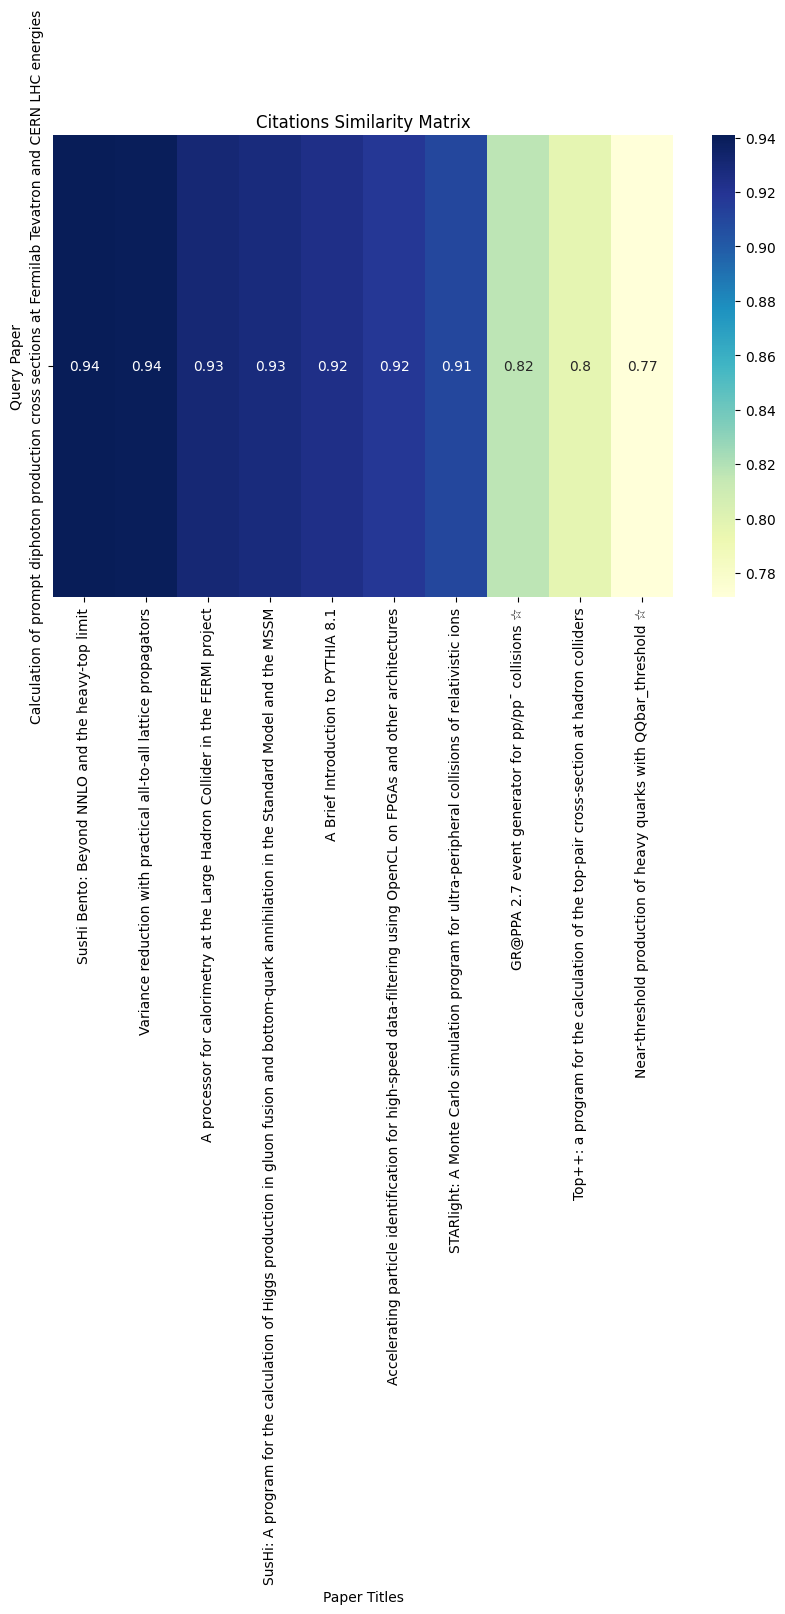


Do you want recommendations for similar papers? (yes/no): yes
On what basis? (author/title/abstract): title

Top similar papers based on title:
Title: Top++: a program for the calculation of the top-pair cross-section at hadron colliders, Similarity Score: 0.7507
Title: SusHi: A program for the calculation of Higgs production in gluon fusion and bottom-quark annihilation in the Standard Model and the MSSM, Similarity Score: 0.9940
Title: Analysis of the ATLAS Rome production experience on the LHC computing grid, Similarity Score: 1.0424
Title: A processor for calorimetry at the Large Hadron Collider in the FERMI project, Similarity Score: 1.1106
Title: DRoplet and hAdron generator for nuclear collisions: An update, Similarity Score: 1.1385


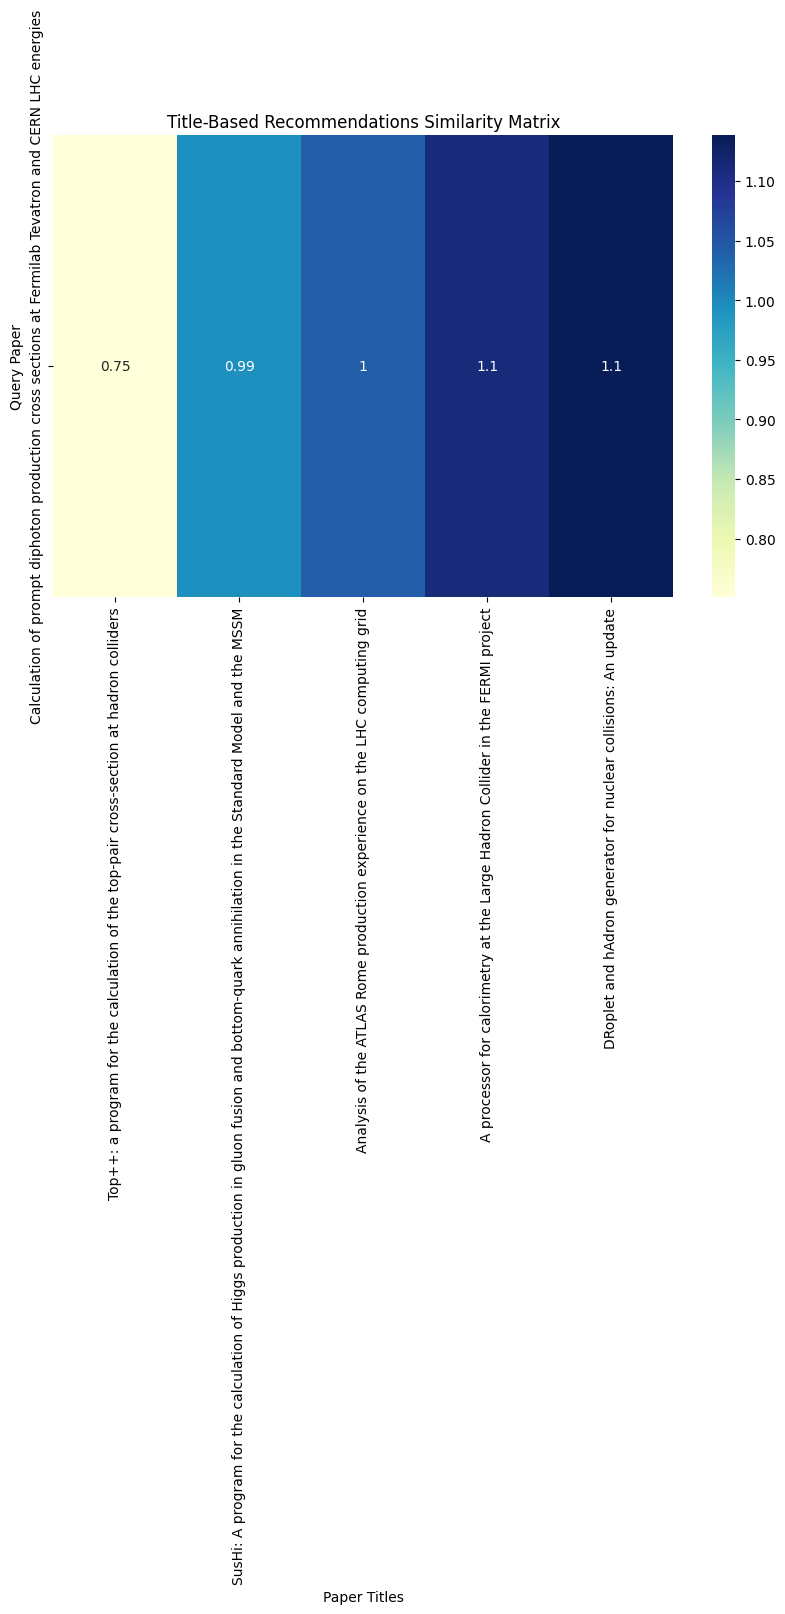

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import umap
import numpy as np
import pandas as pd
import os

def plot_similarity_matrix(query, similar_papers, title="Similarity Matrix"):
    similarity_scores = similar_papers['similarity'].values.reshape(1, -1)

    plt.figure(figsize=(10, 6))
    sns.heatmap(similarity_scores, annot=True, cmap="YlGnBu", xticklabels=similar_papers['title'], yticklabels=[query])
    plt.title(title)
    plt.xlabel("Paper Titles")
    plt.ylabel("Query Paper")
    plt.show()

def plot_embeddings(df, model, column='title', reduction_method='TSNE', n_components=2):
    # Get embeddings for the specified column
    embeddings = model.encode(df[column].tolist())

    # Calculate appropriate perplexity for t-SNE
    n_samples = len(df)
    perplexity = min(30, n_samples - 1)  # Default is 30, but ensure it's less than n_samples

    if reduction_method == 'TSNE':
        reducer = TSNE(n_components=n_components,
                      random_state=42,
                      perplexity=perplexity)
    elif reduction_method == 'UMAP':
        reducer = umap.UMAP(n_components=n_components,
                          random_state=42)
    else:
        raise ValueError("Invalid reduction method. Choose 'TSNE' or 'UMAP'.")

    # Perform dimensionality reduction
    reduced_embeddings = reducer.fit_transform(embeddings)

    # Create a DataFrame for the reduced embeddings
    reduced_df = pd.DataFrame(reduced_embeddings,
                            columns=[f"dim_{i+1}" for i in range(n_components)])
    reduced_df['title'] = df['title']

    # Plot using Plotly
    fig = px.scatter(reduced_df,
                    x='dim_1',
                    y='dim_2',
                    text='title',
                    title=f'{reduction_method} Plot of {column}')
    fig.update_traces(textposition='top center')
    fig.show()

def main():
    # Load dataset
    dataset_path = os.path.join(working_directory, "dblp-v10.csv")
    df = load_dataset(dataset_path)

    # User input: DOI or title
    user_input = input("Enter DOI or title of the paper: ").strip()
    metadata = None

    if user_input.startswith("10."):  # DOI
        metadata = fetch_paper_metadata(user_input)
    else:  # title
        metadata = search_paper_by_title(user_input)

    if metadata:
        print("\nPaper Details:")
        print(f"Title: {metadata['title']}")
        print(f"Authors: {metadata['authors']}")
        print(f"Abstract: {metadata['abstract']}")
        print(f"Citations: {metadata['citations_count']}")
        print(f"Citation Title : {metadata['citations_titles']}")
        print(f"References: {metadata['references_count']}")
    else:
        print("No metadata found for the given input.")
        return

    # Ask if advanced comparison is needed
    compare = input("\nDo you want to compare citations and find similar papers? (yes/no): ").strip().lower()
    if compare == "yes":
        similar_papers = compare_citations_and_find_similar(
            metadata, model, title_index, abstract_index, df, top_k=10
        )
        if similar_papers is None or similar_papers.empty:
            print("No similar papers found.")
        else:
            print("\nTop 10 similar papers based on abstract similarity:")
            for idx, row in similar_papers.iterrows():
                print(f"Title: {row['title']}, Similarity Score: {row['similarity']:.4f}")

            plot_similarity_matrix(metadata['title'], similar_papers,
                                 title="Citations Similarity Matrix")

            # Only visualize if we have enough samples
            if len(similar_papers) > 1:
                plot_embeddings(similar_papers, model, column='title',
                              reduction_method='TSNE')
    # Ask if recommendations are needed
    recommend = input("\nDo you want recommendations for similar papers? (yes/no): ").strip().lower()
    if recommend == "yes":
        basis = input("On what basis? (author/title/abstract): ").strip().lower()

        if basis == "author":
            similar_papers = recommend_papers_by_authors(
                metadata['authors'], df,
                exclude_title=metadata['title'],
                top_k=5
            )

            if similar_papers.empty:
                print("No papers found by the same authors.")
            else:
                print(f"\nTop papers by the same authors:")
                for idx, row in similar_papers.iterrows():
                    print(f"Title: {row['title']}, Authors: {row['authors']}")

                plot_similarity_matrix(
                    metadata['title'],
                    similar_papers,
                    title="Author-Based Recommendations Similarity Matrix"
                )

                if len(similar_papers) > 1:
                    plot_embeddings(similar_papers, model, column='title',
                                  reduction_method='UMAP')

        elif basis in ['title', 'abstract']:
            query_text = metadata[basis] if basis in metadata else None
            if not query_text:
                print(f"No data available for the basis '{basis}'.")
                return

            faiss_index = title_index if basis == 'title' else abstract_index
            similar_papers = search_similar_papers(query_text, model,
                                                faiss_index, df, top_k=5)

            if similar_papers.empty:
                print("No similar papers found.")
            else:
                print(f"\nTop similar papers based on {basis}:")
                for idx, row in similar_papers.iterrows():
                    print(f"Title: {row['title']}, Similarity Score: {row['similarity']:.4f}")

                plot_similarity_matrix(
                    metadata['title'],
                    similar_papers,
                    title=f"{basis.capitalize()}-Based Recommendations Similarity Matrix"
                )

                if len(similar_papers) > 1:
                    plot_embeddings(similar_papers, model, column=basis,
                                  reduction_method='TSNE')

        else:
            print("Invalid option. Please choose 'author', 'title', or 'abstract'.")
    else:
        print("No recommendations provided.")

if __name__ == "__main__":
    main()

In [ ]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=65fbb77b204ec2aaf0048dabab7cbdd33960165672d9074e047507a54fc6f135
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
# Install required packages
!pip install pyngrok streamlit faiss-cpu sentence-transformers plotly scikit-learn umap-learn

import streamlit as st
import os
import faiss
import requests
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import umap
from pyngrok import ngrok, conf
import subprocess

def init_ngrok():
    # Initialize ngrok (this must be done before creating any tunnels)
    NGROK_TOKEN = st.text_input(
        "Enter your ngrok authtoken (from https://dashboard.ngrok.com/get-started/your-authtoken):",
        type="password"
    )

    if NGROK_TOKEN:
        try:
            ngrok.set_auth_token(NGROK_TOKEN)
            st.success("Ngrok authentication successful!")

            # Kill any existing Streamlit processes
            try:
                subprocess.run(['killall', 'streamlit'], stderr=subprocess.DEVNULL)
            except:
                pass

            # Create tunnel
            public_url = ngrok.connect(port='8501')
            st.write(f"Streamlit app URL: {public_url}")
            return True

        except Exception as e:
            st.error(f"Error setting up ngrok: {str(e)}")
            return False
    else:
        st.warning("Please enter your ngrok authtoken to continue")
        return False

# Initialize model and configurations
@st.cache_resource
def initialize_model():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    return SentenceTransformer('all-MiniLM-L6-v2', device=device)

@st.cache_resource
def load_indices(working_directory):
    abstract_index = faiss.read_index(
        os.path.join(working_directory, "abstract_index.faiss")
    )
    title_index = faiss.read_index(
        os.path.join(working_directory, "title_index.faiss")
    )
    return abstract_index, title_index

@st.cache_data
def load_dataset(dataset_path):
    return pd.read_csv(dataset_path)

def fetch_paper_metadata(doi):
    url = f"https://api.semanticscholar.org/v1/paper/{doi}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return {
            "title": data.get("title", "N/A"),
            "authors": ", ".join([author.get("name", "") for author in data.get("authors", [])]),
            "abstract": data.get("abstract", "N/A"),
            "citations_count": len(data.get("citations", [])),
            "citations_titles": [citation.get("title", "N/A") for citation in data.get("citations", [])],
            "references_count": len(data.get("references", []))
        }
    return None

def search_paper_by_title(title):
    url = f"https://api.semanticscholar.org/graph/v1/paper/search?query={title}&fields=title,abstract,authors,citations,references"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data.get("data"):
            paper = data["data"][0]
            return {
                "doi": paper.get("paperId", "N/A"),
                "title": paper.get("title", "N/A"),
                "abstract": paper.get("abstract", "N/A"),
                "authors": ", ".join([author["name"] for author in paper.get("authors", [])]),
                "citations_count": len(paper.get("citations", [])),
                "citations_titles": [citation.get("title", "N/A") for citation in paper.get("citations", [])],
                "references_count": len(paper.get("references", []))
            }
    return None

def plot_similarity_heatmap(query, similar_papers):
    similarity_scores = similar_papers['similarity'].values.reshape(1, -1)
    fig = go.Figure(data=go.Heatmap(
        z=similarity_scores,
        x=similar_papers['title'],
        y=[query],
        colorscale="YlGnBu",
        text=np.around(similarity_scores, decimals=4),
        texttemplate="%{text}",
        textfont={"size": 10},
        showscale=True
    ))
    fig.update_layout(
        title="Similarity Matrix",
        xaxis_title="Paper Titles",
        yaxis_title="Query Paper",
        height=400
    )
    return fig

def plot_embeddings_interactive(df, model, column='title', reduction_method='TSNE'):
    embeddings = model.encode(df[column].tolist())
    n_samples = len(df)
    perplexity = min(30, n_samples - 1)

    if reduction_method == 'TSNE':
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    else:
        reducer = umap.UMAP(n_components=2, random_state=42)

    reduced_embeddings = reducer.fit_transform(embeddings)

    fig = px.scatter(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        text=df['title'],
        title=f'{reduction_method} Visualization'
    )
    fig.update_traces(textposition='top center')
    fig.update_layout(height=600)
    return fig

def compare_citations_and_find_similar(doi_metadata, model, title_index, abstract_index, df, top_k=10):
    cited_titles = doi_metadata.get("citations_titles", [])
    paper_abstract = doi_metadata.get("abstract", "")

    if not cited_titles or not paper_abstract:
        return None

    query_embedding = model.encode([paper_abstract])
    distances, indices = abstract_index.search(query_embedding, top_k)

    similar_papers = df.iloc[indices[0]].copy()
    similar_papers['similarity'] = distances[0]

    return similar_papers.sort_values(by="similarity", ascending=False).head(10)

def recommend_papers(metadata, df, model, title_index, abstract_index, basis='author', top_k=5):
    if basis == 'author':
        author_pattern = "|".join([f"(?i){author.strip()}" for author in metadata['authors'].split(",")])
        matches = df[df['authors'].str.contains(author_pattern, na=False)]
        matches = matches[matches['title'] != metadata['title']]
        return matches.head(top_k)
    else:
        query_text = metadata[basis] if basis in metadata else None
        if not query_text:
            return None

        faiss_index = title_index if basis == 'title' else abstract_index
        query_embedding = model.encode([query_text])
        distances, indices = faiss_index.search(query_embedding, top_k)

        similar_papers = df.iloc[indices[0]].copy()
        similar_papers['similarity'] = distances[0]
        return similar_papers

def main():
    st.set_page_config(page_title="Research Paper Explorer", layout="wide")

    st.title("\ud83d\udcda Research Paper Explorer")
    if not init_ngrok():
        st.stop()

    model = initialize_model()

    working_directory = "."
    dataset_path = "dblp-v10.csv"

    try:
        abstract_index, title_index = load_indices(working_directory)
        df = load_dataset(dataset_path)
    except FileNotFoundError:
        st.error("Required files not found. Please ensure abstract_index.faiss, title_index.faiss, and dblp-v10.csv are in the current directory.")
        st.stop()

    search_col1, search_col2 = st.columns([2, 1])
    with search_col1:
        search_query = st.text_input("Enter paper DOI or title:")
    with search_col2:
        search_type = st.selectbox("Search type:", ["DOI", "Title"])

    if search_query:
        metadata = None
        with st.spinner("Fetching paper information..."):
            if search_type == "DOI":
                metadata = fetch_paper_metadata(search_query)
            else:
                metadata = search_paper_by_title(search_query)

        if metadata:
            st.subheader("Paper Details")
            st.write(f"**Title:** {metadata['title']}")
            st.write(f"**Authors:** {metadata['authors']}")
            st.write(f"**Abstract:** {metadata['abstract']}")
            st.write(f"**Citations Count:** {metadata['citations_count']}")
            st.write(f"**References Count:** {metadata['references_count']}")

            st.subheader("Recommendations")
            basis = st.radio("Recommend based on:", ["author", "title", "abstract"])
            recommendations = recommend_papers(metadata, df, model, title_index, abstract_index, basis=basis)

            if recommendations is not None and not recommendations.empty:
                st.write(recommendations[['title', 'authors', 'similarity']])
            else:
                st.write("No recommendations found.")

            st.subheader("Citation Similarity")
            similar_papers = compare_citations_and_find_similar(metadata, model, title_index, abstract_index, df)
            if similar_papers is not None:
                st.write(similar_papers[['title', 'authors', 'similarity']])
                heatmap = plot_similarity_heatmap(metadata['title'], similar_papers)
                st.plotly_chart(heatmap, use_container_width=True)
            else:
                st.write("No similar papers found based on citations.")

            st.subheader("Visualization")
            reduction_method = st.selectbox("Reduction method:", ["TSNE", "UMAP"])
            vis_fig = plot_embeddings_interactive(df, model, column="title", reduction_method=reduction_method)
            st.plotly_chart(vis_fig, use_container_width=True)
        else:
            st.error("Paper not found. Please check the input and try again.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


2024-12-09 08:27:20.154 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token('2pyC1DBzsvlOm7pSydSSJedAg9y_6mgaJppHiZUbLwfQUnwvK')  # Replace with your actual token


#FLASK API


In [ ]:
import os
import faiss
import requests
import pandas as pd
from flask import Flask, request, jsonify
from flask_cors import CORS
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyngrok import ngrok

app = Flask(__name__)
CORS(app)

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Load dataset and FAISS indices
working_directory = "/content/drive/My Drive/NLP/NLP_Project"  # Update this path
dataset_path = os.path.join(working_directory, "dblp-v10.csv")
abstract_index_path = os.path.join(working_directory, "abstract_index.faiss")
title_index_path = os.path.join(working_directory, "title_index.faiss")

df = pd.read_csv(dataset_path)
abstract_index = faiss.read_index(abstract_index_path)
title_index = faiss.read_index(title_index_path)

def fetch_paper_metadata(doi):
    url = f"https://api.semanticscholar.org/v1/paper/{doi}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        metadata = {
            "title": data.get("title", "N/A"),
            "authors": ", ".join([author.get("name", "") for author in data.get("authors", [])]),
            "abstract": data.get("abstract", "N/A"),
            "citations_count": len(data.get("citations", [])),
            "citations_titles": [citation.get("title", "N/A") for citation in data.get("citations", [])],
            "references_count": len(data.get("references", []))
        }
        return metadata
    return None

def search_paper_by_title(title):
    url = f"https://api.semanticscholar.org/graph/v1/paper/search?query={title}&fields=title,abstract,authors,citations,references"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data.get("data"):
            paper = data["data"][0]  # Take the first match
            return {
                "doi": paper.get("paperId", "N/A"),
                "title": paper.get("title", "N/A"),
                "abstract": paper.get("abstract", "N/A"),
                "authors": ", ".join([author["name"] for author in paper.get("authors", [])]),
                "citations_count": len(paper.get("citations", [])),
                "citations_titles": [citation.get("title", "N/A") for citation in data.get("citations", [])],
                "references_count": len(paper.get("references", []))
            }
    return None

def search_similar_papers(query, faiss_index, top_k=5):
    query_embedding = model.encode([query])
    distances, indices = faiss_index.search(query_embedding, top_k)
    results = df.iloc[indices[0]].copy()
    results['similarity'] = 1 - distances[0]  # Convert distance to similarity score
    return results.to_dict('records')

def recommend_papers_by_authors(authors, exclude_title=None, top_k=5):
    # Find papers written by any of the given authors
    author_pattern = "|".join([f"(?i){author.strip()}" for author in authors.split(",")])
    matches = df[df['authors'].str.contains(author_pattern, na=False)]

    # Exclude the current paper if specified
    if exclude_title:
        matches = matches[matches['title'] != exclude_title]

    # Add similarity score (could be enhanced with more sophisticated scoring)
    matches_with_scores = matches.head(top_k).copy()
    matches_with_scores['similarity'] = 0.95  # Placeholder similarity score

    return matches_with_scores.to_dict('records')

def compare_citations_and_find_similar(doi_metadata, top_k=10):
    cited_titles = doi_metadata.get("citations_titles", [])
    paper_abstract = doi_metadata.get("abstract", "")

    if not cited_titles:
        return {"error": "No citation titles available for comparison."}

    if not paper_abstract:
        return {"error": "Abstract of the entered paper is unavailable."}

    # Compare abstracts
    query_embedding = model.encode([paper_abstract])
    distances, indices = abstract_index.search(query_embedding, top_k)

    # Get top similar papers
    similar_papers = df.iloc[indices[0]].copy()
    similar_papers['similarity'] = 1 - distances[0]  # Convert distance to similarity score

    return similar_papers.sort_values(by="similarity", ascending=False).head(10).to_dict('records')

@app.route('/api/search', methods=['POST'])
def search_paper():
    data = request.json
    query = data.get('query')

    if not query:
        return jsonify({"error": "No query provided"}), 400

    if query.startswith("10."):  # DOI
        metadata = fetch_paper_metadata(query)
    else:  # title
        metadata = search_paper_by_title(query)

    if metadata:
        return jsonify(metadata)
    else:
        return jsonify({"error": "Paper not found"}), 404

@app.route('/api/recommend', methods=['POST'])
def recommend():
    data = request.json
    basis = data.get('basis')
    query = data.get('query')
    exclude_title = data.get('exclude_title')
    top_k = data.get('top_k', 5)

    if not basis or not query:
        return jsonify({"error": "Missing 'basis' or 'query' in request"}), 400

    try:
        if basis == 'author':
            # Use author-based recommendation
            results = recommend_papers_by_authors(
                authors=query,
                exclude_title=exclude_title,
                top_k=top_k
            )

        elif basis == 'title':
            # Use title-based recommendation with FAISS
            results = search_similar_papers(
                query=query,
                faiss_index=title_index,
                top_k=top_k
            )

        elif basis == 'abstract':
            # Use abstract-based recommendation with FAISS
            results = search_similar_papers(
                query=query,
                faiss_index=abstract_index,
                top_k=top_k
            )
        else:
            return jsonify({"error": "Invalid basis. Choose 'title', 'abstract', or 'author'"}), 400

        # Filter out the original paper if exclude_title is provided
        if exclude_title:
            results = [paper for paper in results if paper['title'] != exclude_title]

        return jsonify({"recommendations": results})

    except Exception as e:
        print(f"Error in recommend endpoint: {str(e)}")
        return jsonify({"error": "An error occurred while processing your request"}), 500

@app.route('/api/similar_papers', methods=['POST'])
def get_similar_papers():
    data = request.json
    paper_abstract = data.get('abstract', '')

    if not paper_abstract:
        return jsonify({"error": "Abstract is required"}), 400

    similar_papers = search_similar_papers(paper_abstract, abstract_index, top_k=10)
    return jsonify({"similar_papers": similar_papers})

@app.route('/api/compare_citations', methods=['POST'])
def compare_citations():
    data = request.json
    doi_metadata = data.get('metadata')

    if not doi_metadata:
        return jsonify({"error": "Paper metadata is required"}), 400

    similar_papers = compare_citations_and_find_similar(doi_metadata)
    return jsonify({"similar_papers": similar_papers})

if __name__ == '__main__':
    # Start the Flask app
    # Set up ngrok tunnel
    public_url = ngrok.connect(5000)
    print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")

    app.run(debug=True, use_reloader=False, port=5000)

 * ngrok tunnel "NgrokTunnel: "https://d7a2-34-125-18-204.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:17:52] "OPTIONS /api/search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:17:53] "POST /api/search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:17:54] "OPTIONS /api/compare_citations HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:17:55] "POST /api/compare_citations HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:18:15] "OPTIONS /api/search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:18:16] "POST /api/search HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:18:21] "OPTIONS /api/recommend HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Dec/2024 01:18:22] "POST /api/recommend HTTP/1.1" 200 -


In [ ]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 26.4 MB/s eta 0:00:00
